In [39]:
#Notebook taken and modified from https://nbviewer.org/url/arteagac.github.io/blog/lime_image.ipynb

import numpy as np
import skimage.io 
import skimage.segmentation
import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import os
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt

In [40]:
folder = 'pickle'
inner_folder = 'augmented'

with open(os.path.join(folder, inner_folder, 'model_pickle'), 'rb') as f:
    model = pickle.load(f)

In [41]:
class_names = ["ABE", "ART", "BAS", "BLA", "EBO", "EOS", "FGC", "KSC", "LYI", "LYT", "MMZ", "MON", "MYB", "NGB", "NGS", "NIF", "OTH", "PEB", "PLM", "PMO"]

1/1 [==============================] - 0s 16ms/step


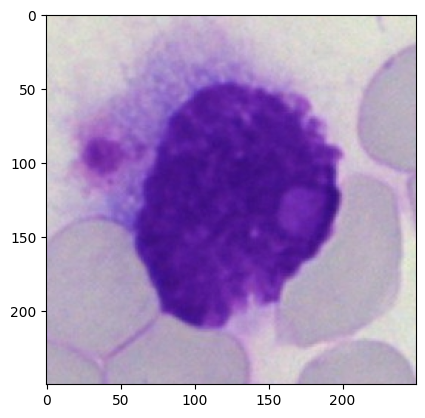

In [43]:
img = skimage.io.imread("Validation/ART/ART_00009.jpg")
# show image
plt.imshow(img)
yhat = model.predict(np.expand_dims(img/255, 0))

In [44]:
superpixels = skimage.segmentation.quickshift(img, kernel_size=4,max_dist=200, ratio=0.2)
print(superpixels)
num_superpixels = np.unique(superpixels).shape[0]
# Number of superpixels in the given image
num_superpixels

[[ 1  1  1 ...  3  3  3]
 [ 1  1  1 ...  3  3  3]
 [ 1  1  1 ...  3  3  3]
 ...
 [41 41 41 ... 42 42 42]
 [41 41 41 ... 42 42 42]
 [41 41 41 ... 42 42 42]]


43

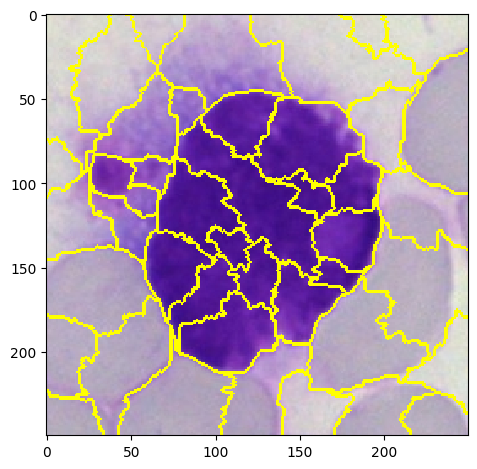

In [45]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(img, superpixels))

In [46]:
num_perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
perturbations[0] #Show example of perturbation

array([0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1])

In [47]:
def perturb_image(img, perturbation, segments):
    active_pixels = np.where(perturbation == 1)[0]
    mask = np.zeros(segments.shape)
    for active in active_pixels:
        mask[segments == active] = 1 
    perturbed_image = copy.deepcopy(img)
    perturbed_image = perturbed_image * mask[:, :, np.newaxis]
    perturbed_image += (1 - mask[:, :, np.newaxis]) * 128
    
    # Normalize to the range [0, 1]
    perturbed_image = perturbed_image / 255.0
    return perturbed_image

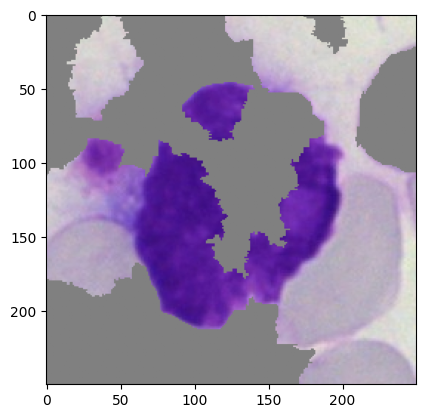

In [48]:
plt.imshow(perturb_image(img, perturbations[0], superpixels))
plt.show()

In [49]:
perturbed_img = perturb_image(img,perturbations[0],superpixels)
yhat = model.predict(perturbed_img[np.newaxis,:,:,:])
max_index = np.argmax(yhat)
yhat

1/1 [==============================] - 0s 20ms/step


array([[8.0146481e-22, 6.4814490e-01, 7.3103520e-06, 4.0462968e-05,
        1.7895681e-04, 6.7249918e-04, 2.2690986e-14, 7.8354900e-10,
        7.7631972e-09, 2.3372402e-15, 2.8609767e-04, 1.3517569e-04,
        7.0392634e-05, 1.0828596e-04, 9.4282757e-03, 3.3770087e-01,
        3.1813043e-03, 3.6966044e-09, 4.0454134e-07, 1.0286955e-05,
        3.4832796e-05]], dtype=float32)

In [50]:
predictions = []
for pert in perturbations:
    perturbed_img = perturb_image(img,pert,superpixels)
    pred = model.predict(perturbed_img[np.newaxis,:,:,:])
    predictions.append(pred)

predictions = np.array(predictions)
predictions.shape

1/1 [==============================] - 0s 19ms/step


(150, 1, 21)

In [51]:
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
distances.shape

(150,)

In [52]:
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
weights.shape

(150,)

In [53]:
class_to_explain = max_index
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]
coeff

array([ 0.0198913 ,  0.00856853,  0.01936753, -0.02499385,  0.00048798,
        0.04956443,  0.0420673 , -0.07660179, -0.01927669, -0.07443889,
       -0.0800194 ,  0.00611879, -0.13843179, -0.01153278, -0.06289979,
       -0.01933847, -0.02723836,  0.10676127,  0.03772269, -0.05244163,
        0.05110088, -0.00984578, -0.02170407, -0.03151151,  0.0140856 ,
       -0.09223259, -0.07442655,  0.01630394, -0.08224533, -0.02754675,
        0.02991014, -0.04313885, -0.06123742, -0.11420883, -0.05270883,
       -0.03626433,  0.02319074, -0.01204625,  0.04939036, -0.00720294,
        0.03729115,  0.03725842,  0.00857742])

In [54]:
num_top_features = 5
top_features = np.argsort(coeff)[-num_top_features:] 
top_features

array([ 6, 38,  5, 20, 17])

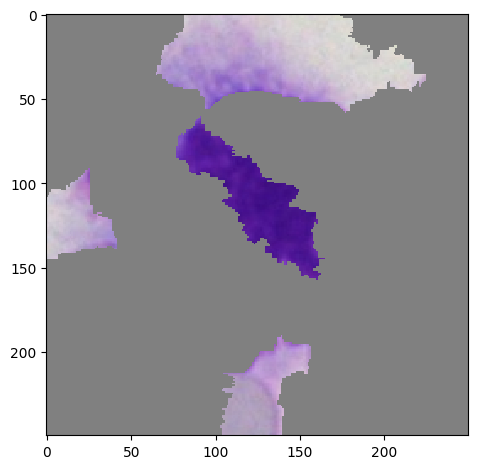

In [55]:
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(img,mask,superpixels))

In [56]:
perturbed_img = perturb_image(img,mask,superpixels)

# check dimensions of perturbed_img
print(perturbed_img.shape)

yhat = model.predict(perturbed_img[np.newaxis,:,:,:])
max_index = np.argmax(yhat)
print(yhat)
max_index = np.argmax(yhat)
print(class_names[max_index])

(250, 250, 3)
1/1 [==============================] - 0s 19ms/step
[[2.7889408e-18 9.8150587e-01 5.2606156e-05 3.6108717e-03 7.5246731e-04
  3.5342618e-04 1.5840364e-11 5.3883241e-06 2.4561887e-06 1.8879347e-10
  3.2635948e-03 8.2067098e-05 1.6781075e-04 1.3970259e-04 2.3120038e-04
  4.0236730e-03 5.4985341e-03 2.8969914e-06 3.8427029e-06 2.1155969e-04
  9.2001821e-05]]
ART
